# Importing relevant things

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from torch import nn, optim
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Subset, TensorDataset
import os
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
import torch.nn.functional as F
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from pytorch_msssim import SSIM
from cifar_dataset import *
from ucc_dataset import *
from rcc_dataset import *
from dataloaders import *
from device_data_loader import *
from loss import *
from model import *
from params import *
from utils import *
from rcc_trainer import *
from ucc_trainer import *
from autoencoder_trainer import *


## Creating the dataset object

In [3]:
dataloaders = Dataloaders()

# EXPERIMENT-1 : UCC Model

This model tries to replicate the paper where we have an autoencoder path and a ucc path.

Similarly experiment-2 will be the improvement model

## Creating the model instances


In [4]:
experiment1 = "ucc"
save_dir = os.path.abspath(config.weights_path)
combined_ucc_model = UCCModel().to(config.device)

#creating the trainer
ucc_trainer = UCCTrainer(experiment1, combined_ucc_model, dataloaders, save_dir)

KDE Layer initialized
UCC model initialized


## Training the model

Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

Reshaped the original image into bag format
Got a sample reconstruction, now trying to reshape in order to show an example


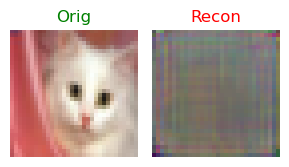

[TRAIN]:Step: 1000 | Loss: 0.736221195936203 | AE Loss: 0.08559037977457047 | UCC Loss: 1.3868520095348358 | UCC Acc: 0.2523
[VAL]:Step: 1000 | Val Loss: 0.7243745732307434 | Val AE Loss: 0.06229062378406525 | Val UCC Loss: 1.3864585292339324 | Val UCC Acc: 0.25

------------------------------------------------------------
Going to save model ucc @ Step:1000
Saved the model checkpoint for experiment ucc for step 1001
Reshaped the original image into bag format
Got a sample reconstruction, now trying to reshape in order to show an example


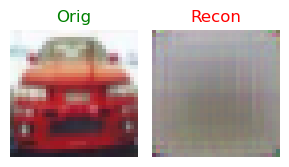

[TRAIN]:Step: 2000 | Loss: 0.7237741678953171 | AE Loss: 0.06107812447845936 | UCC Loss: 1.3864702101945876 | UCC Acc: 0.24845
[VAL]:Step: 2000 | Val Loss: 0.7219959229230881 | Val AE Loss: 0.05772359050810337 | Val UCC Loss: 1.3862682557106019 | Val UCC Acc: 0.252

------------------------------------------------------------
Going to save model ucc @ Step:2000
Saved the model checkpoint for experiment ucc for step 2001


KeyboardInterrupt: 

In [5]:
exp1_epoch_numbers, exp1_training_ae_losses, exp1_training_ucc_losses, exp1_training_losses, exp1_training_ucc_accuracies, exp1_val_ae_losses, exp1_val_ucc_losses, exp1_val_losses, exp1_val_ucc_accuracies = ucc_trainer.train()

|## Additional Training if required

In [6]:
# exp1_epoch_numbers, exp1_training_ae_losses, exp1_training_ucc_losses, exp1_training_losses, exp1_training_ucc_accuracies, exp1_val_ae_losses, exp1_val_ucc_losses, exp1_val_losses, exp1_val_ucc_accuracies = ucc_trainer.train(resume_steps=101, load_from_checkpoint=True)

## Plotting the model stats

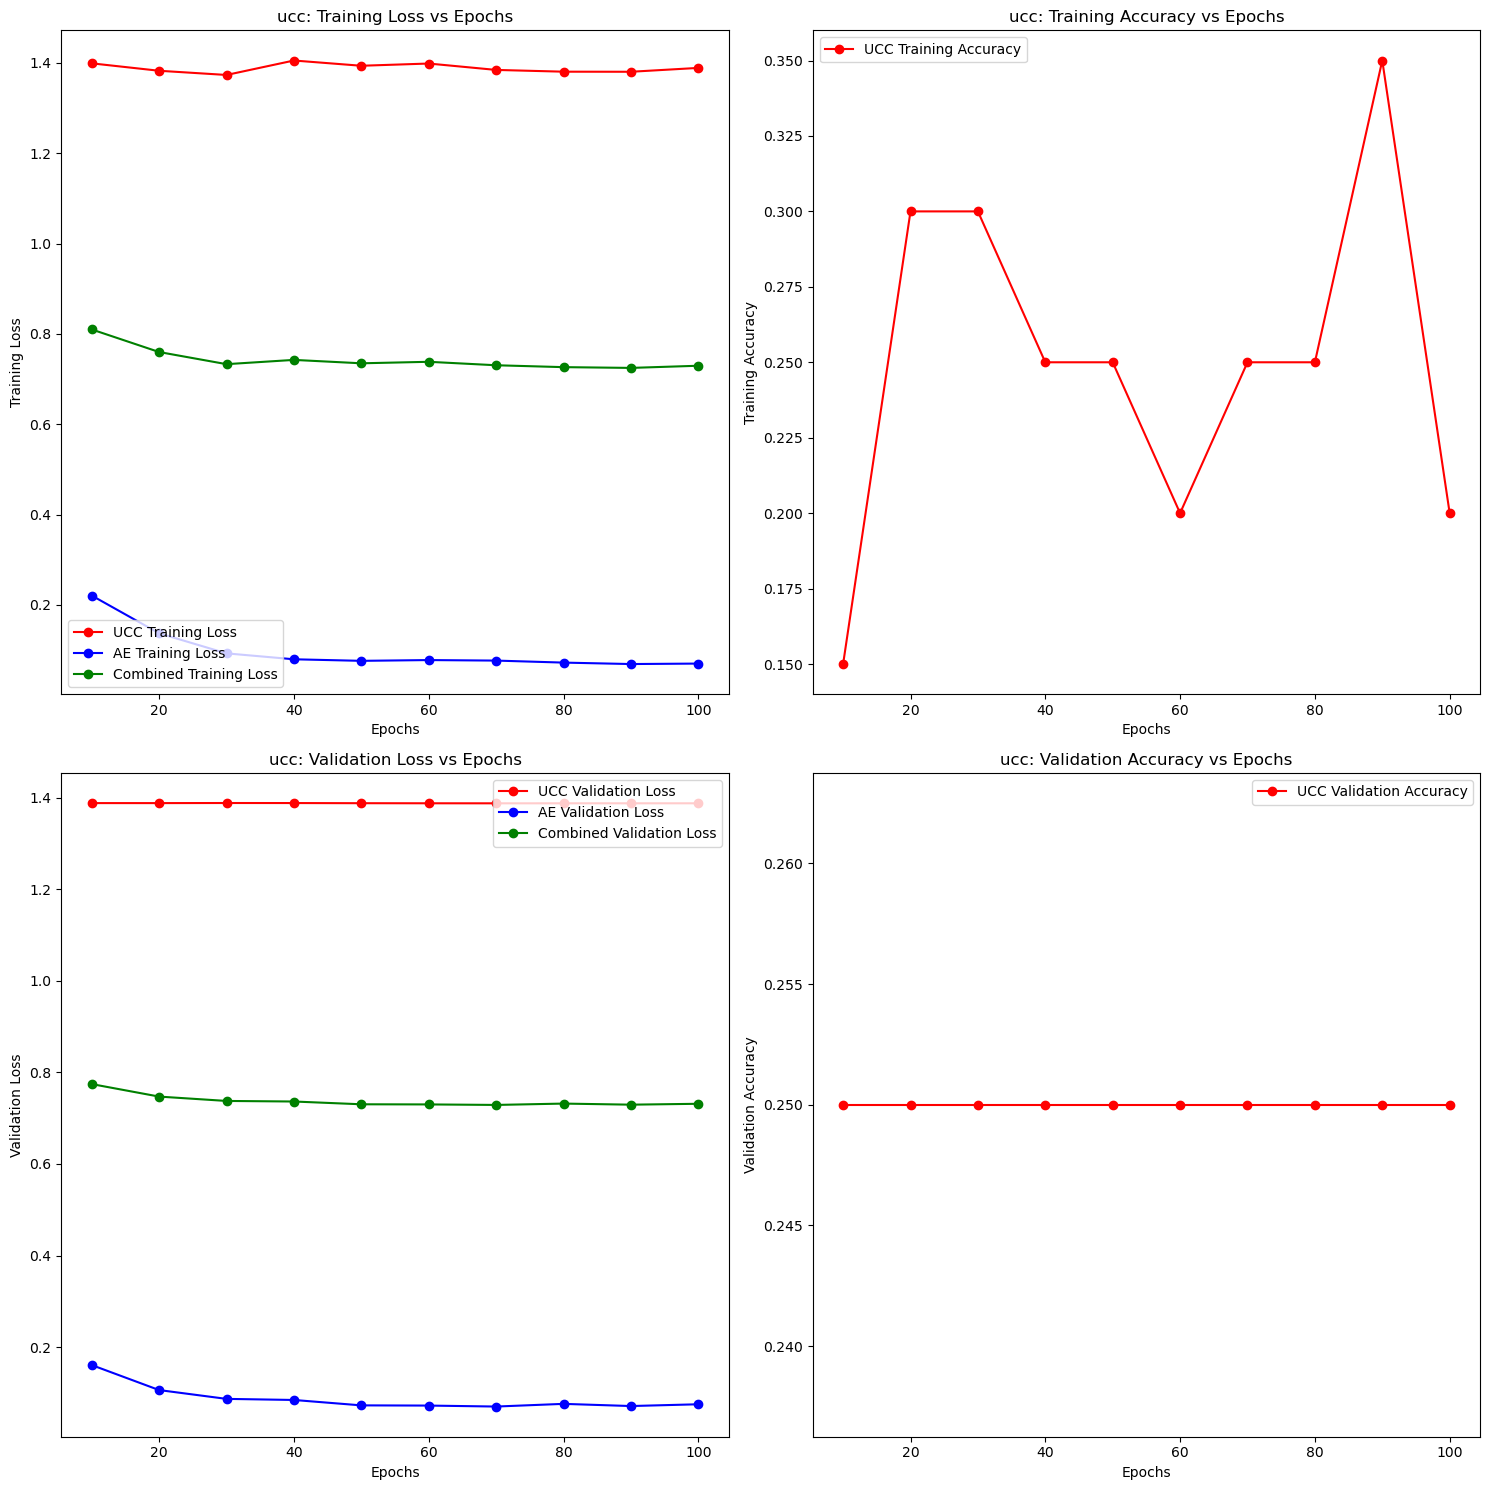

In [7]:
plot_ucc_model_stats(experiment1, exp1_epoch_numbers, exp1_training_ucc_losses, exp1_training_ae_losses, exp1_training_losses,
                     exp1_training_ucc_accuracies, exp1_val_ucc_losses, exp1_val_ae_losses, exp1_val_losses,
                     exp1_val_ucc_accuracies)

## Testing the model

Reshaped the original image into bag format
Got a sample reconstruction, now trying to reshape in order to show an example


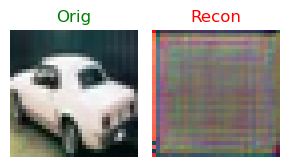

{'avg_test_loss': 0.7287247383594513,
 'avg_test_ae_loss': 0.06990872107446194,
 'avg_test_ucc_loss': 1.3875407564640045,
 'avg_test_ucc_training_accuracy': 0.25}

In [8]:
ucc_trainer.test_model()

In [9]:
ucc_trainer.compute_clustering_accuracy()

  0%|          | 0/100 [00:00<?, ?it/s]

Computed all the features from the encoder


C:\Users\paras\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Performed clustering and computed all the cluster labels
Going to perform linear sum assignment of cost matrix
Clustering accuracy is 0.25


0.25

In [10]:
ucc_trainer.compute_min_js_divergence()

  0%|          | 0/100 [00:00<?, ?it/s]

Got the KDE distributions for the test dataset
Got the average kde distribution per label class, now computing min js divergence
Computed all interclass js divergence scores, the entire interclass js divergence is 
[[            inf  4.16479637e-07  1.14017432e-07  5.21775448e-07
   6.39572761e-07  1.13047321e-06  7.72683876e-07  3.51838274e-07
   6.00992811e-08  7.70750290e-08]
 [ 4.16479637e-07             inf  4.89594726e-07  5.49937038e-08
   1.46445455e-07  3.53981008e-07  2.34640453e-07  7.69245796e-08
   2.54136545e-07  2.09798259e-08]
 [ 1.14017432e-07  4.89594726e-07             inf  4.92692919e-07
   6.30167108e-07  1.00932863e-06  7.04713671e-07  3.08028220e-07
   1.02410020e-07  7.61206564e-08]
 [ 5.21775448e-07  5.49937038e-08  4.92692919e-07             inf
   1.37298283e-07  3.56273830e-07  2.83151493e-07  2.83923041e-08
   2.78695143e-07  3.61850887e-07]
 [ 6.39572761e-07  1.46445455e-07  6.30167108e-07  1.37298283e-07
              inf -1.44012066e-07 -6.30017807e-08  

-1.440120662721256e-07